# Local Setup Instructions

## Prerequisites Checklist

Before running this notebook, ensure you have completed the following setup:

- [ ] **Conda environment `fraud-shield` created and activated**
- [ ] **Preprocessed data and trained models available**
  - Run `02-local-preprocessing.ipynb` first
  - Run `04-local-supervised-models.ipynb` first
  - Run `05-local-deep-learning.ipynb` first
  - Run `06-local-transformers.ipynb` first

## Environment Activation

```bash
conda activate fraud-shield
```

# Hybrid Ensemble Framework for Fraud Detection

**Notebook:** 07-local-hybrid-framework.ipynb
**Objective:** Combine XGBoost and MLP predictions into hybrid ensembles using the 30-feature leak-free dataset.

## Base Models

- **XGBoost** (Optuna-tuned, from NB04)
- **MLP** (Focal Loss, from NB05)

## Ensemble Approaches

1. **Soft Voting:** Average predicted probabilities from base models
2. **Weighted Ensemble:** Weight models by their validation PR-AUC
3. **Stacking:** Use base model predictions as features for a Logistic Regression meta-learner

In [1]:
# ============================================================
# GLOBAL IMPORTS & DEPENDENCIES
# ============================================================

import os
import sys
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import joblib

import torch
import torch.nn as nn
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

print("All dependencies loaded successfully")

All dependencies loaded successfully


In [2]:
# ============================================================
# CONFIGURATION & PATHS
# ============================================================

NOTEBOOK_DIR = Path.cwd()
if NOTEBOOK_DIR.name == "local_notebooks":
    PROJECT_ROOT = NOTEBOOK_DIR.parent
else:
    PROJECT_ROOT = NOTEBOOK_DIR

os.chdir(PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
RESULTS_DIR = PROJECT_ROOT / "results"

MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

PREPROCESSED_TRAIN_PATH = PROCESSED_DATA_DIR / 'train_preprocessed.parquet'
PREPROCESSED_VAL_PATH = PROCESSED_DATA_DIR / 'val_preprocessed.parquet'
PREPROCESSED_TEST_PATH = PROCESSED_DATA_DIR / 'test_preprocessed.parquet'
FEATURE_NAMES_PATH = MODELS_DIR / 'feature_names.pkl'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Project root: {PROJECT_ROOT}")
print(f"Device: {DEVICE}")

Project root: /home/alireza/Desktop/projects/fraud-shield-ai
Device: cuda


## 1. Load Data and Trained Models

In [3]:
# ============================================================
# LOAD PREPROCESSED DATA
# ============================================================

train_df = pd.read_parquet(PREPROCESSED_TRAIN_PATH)
val_df = pd.read_parquet(PREPROCESSED_VAL_PATH)
test_df = pd.read_parquet(PREPROCESSED_TEST_PATH)

# Rename columns
if FEATURE_NAMES_PATH.exists():
    with open(FEATURE_NAMES_PATH, 'rb') as f:
        feature_names = pickle.load(f)
    feature_cols_raw = [col for col in train_df.columns if col != 'is_fraud']
    n = min(len(feature_cols_raw), len(feature_names))
    rename_map = {str(i): feature_names[i] for i in range(n)}
    for df in (train_df, val_df, test_df):
        df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)

feature_cols = [col for col in train_df.columns if col != 'is_fraud']

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df['is_fraud'].values.astype(np.float32)
X_val = val_df[feature_cols].values.astype(np.float32)
y_val = val_df['is_fraud'].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df['is_fraud'].values.astype(np.float32)

print(f"Train: {X_train.shape[0]:,}, Val: {X_val.shape[0]:,}, Test: {X_test.shape[0]:,}")
print(f"Features: {len(feature_cols)}")

Train: 1,034,987, Val: 122,480, Test: 555,719
Features: 37


In [4]:
# ============================================================
# LOAD TRAINED MODELS
# ============================================================

# --- XGBoost ---
xgb_model = joblib.load(MODELS_DIR / 'xgb_best_model.pkl')
xgb_metadata = joblib.load(MODELS_DIR / 'xgb_best_model_metadata.pkl')
print(f"XGBoost loaded: {xgb_metadata.get('model_name', 'xgb')}")

# --- Deep Learning (MLP) ---
# Reconstruct MLP architecture
class FraudMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int] = [128, 64, 32], dropout: float = 0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.PReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze(-1)

dl_checkpoint = torch.load(MODELS_DIR / 'dl_best_model.pt', map_location=DEVICE, weights_only=False)
dl_input_dim = dl_checkpoint['input_dim']

# Infer hidden dims from state dict if not stored in checkpoint
dl_hidden = dl_checkpoint.get('hidden_dims', None)
if dl_hidden is None:
    sd = dl_checkpoint['model_state_dict']
    linear_shapes = [v.shape[0] for k, v in sd.items() if k.endswith('.weight') and v.dim() == 2]
    dl_hidden = linear_shapes[:-1] if len(linear_shapes) > 1 else [128, 64, 32]
dl_dropout = dl_checkpoint.get('dropout', 0.3)

dl_model = FraudMLP(input_dim=dl_input_dim, hidden_dims=dl_hidden, dropout=dl_dropout)
dl_model.load_state_dict(dl_checkpoint['model_state_dict'])
dl_model = dl_model.to(DEVICE)
dl_model.eval()
dl_threshold = dl_checkpoint.get('threshold', 0.5)
print(f"DL model loaded: {dl_checkpoint['model_class']}, threshold={dl_threshold:.4f}")

# Load DL scaler
dl_scaler = joblib.load(MODELS_DIR / 'dl_scaler.pkl')

print("\nAll models loaded successfully.")

XGBoost loaded: XGBoost (Optuna-tuned)
DL model loaded: FraudMLP, threshold=0.9942

All models loaded successfully.


## 2. Generate Base Model Predictions

In [5]:
# ============================================================
# GENERATE PREDICTIONS FROM EACH BASE MODEL
# ============================================================

def find_best_threshold(y_true: np.ndarray, y_pred_proba: np.ndarray) -> Tuple[float, float]:
    """Find threshold that maximizes F1."""
    prec, rec, thresh = precision_recall_curve(y_true, y_pred_proba)
    thresh = np.append(thresh, 1.0)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-10)
    idx = np.nanargmax(f1_scores)
    return float(thresh[idx]), float(f1_scores[idx])

def evaluate_at_threshold(
    y_true: np.ndarray, y_proba: np.ndarray, threshold: float, name: str
) -> Dict[str, float]:
    """Evaluate predictions at a given threshold."""
    y_pred = (y_proba >= threshold).astype(int)
    metrics = {
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'pr_auc': average_precision_score(y_true, y_proba)
    }
    print(f"{name} | F1={metrics['f1_score']:.4f} PR-AUC={metrics['pr_auc']:.4f} "
          f"ROC-AUC={metrics['roc_auc']:.4f} P={metrics['precision']:.4f} R={metrics['recall']:.4f}")
    return metrics


# --- XGBoost predictions ---
xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# --- DL predictions (need scaled input) ---
X_val_scaled = dl_scaler.transform(X_val)
X_test_scaled = dl_scaler.transform(X_test)

with torch.no_grad():
    val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(DEVICE)
    dl_val_proba = torch.sigmoid(dl_model(val_tensor)).cpu().numpy()
    test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(DEVICE)
    dl_test_proba = torch.sigmoid(dl_model(test_tensor)).cpu().numpy()

print("Base model predictions:")
print("\nValidation Set:")
xgb_thresh, _ = find_best_threshold(y_val, xgb_val_proba)
dl_thresh, _ = find_best_threshold(y_val, dl_val_proba)

xgb_val_m = evaluate_at_threshold(y_val, xgb_val_proba, xgb_thresh, 'XGBoost')
dl_val_m = evaluate_at_threshold(y_val, dl_val_proba, dl_thresh, 'DL (MLP)')

print("\nTest Set:")
xgb_test_m = evaluate_at_threshold(y_test, xgb_test_proba, xgb_thresh, 'XGBoost')
dl_test_m = evaluate_at_threshold(y_test, dl_test_proba, dl_thresh, 'DL (MLP)')

Base model predictions:

Validation Set:
XGBoost | F1=0.8983 PR-AUC=0.9574 ROC-AUC=0.9995 P=0.9187 R=0.8787
DL (MLP) | F1=0.8612 PR-AUC=0.9196 ROC-AUC=0.9981 P=0.8687 R=0.8538

Test Set:


XGBoost | F1=0.7433 PR-AUC=0.8000 ROC-AUC=0.9939 P=0.8152 R=0.6830


DL (MLP) | F1=0.6546 PR-AUC=0.7179 ROC-AUC=0.9890 P=0.5961 R=0.7259


## 3. Soft Voting Ensemble

In [6]:
# ============================================================
# SOFT VOTING: SIMPLE AVERAGE
# ============================================================

soft_val_proba = (xgb_val_proba + dl_val_proba) / 2
soft_test_proba = (xgb_test_proba + dl_test_proba) / 2

soft_thresh, soft_val_f1 = find_best_threshold(y_val, soft_val_proba)
print(f"Soft Voting threshold: {soft_thresh:.4f}, Val F1: {soft_val_f1:.4f}")

print("\nValidation:")
soft_val_m = evaluate_at_threshold(y_val, soft_val_proba, soft_thresh, 'Soft Voting')
print("\nTest:")
soft_test_m = evaluate_at_threshold(y_test, soft_test_proba, soft_thresh, 'Soft Voting')

Soft Voting threshold: 0.9159, Val F1: 0.9010

Validation:
Soft Voting | F1=0.9010 PR-AUC=0.9524 ROC-AUC=0.9991 P=0.9333 R=0.8709

Test:


Soft Voting | F1=0.7476 PR-AUC=0.8026 ROC-AUC=0.9930 P=0.8218 R=0.6858


## 4. Weighted Ensemble

In [7]:
# ============================================================
# WEIGHTED ENSEMBLE: WEIGHT BY VALIDATION PR-AUC
# ============================================================

w_xgb = xgb_val_m['pr_auc']
w_dl = dl_val_m['pr_auc']
w_total = w_xgb + w_dl

print(f"Weights: XGBoost={w_xgb/w_total:.3f}, DL={w_dl/w_total:.3f}")

weighted_val_proba = (w_xgb * xgb_val_proba + w_dl * dl_val_proba) / w_total
weighted_test_proba = (w_xgb * xgb_test_proba + w_dl * dl_test_proba) / w_total

weighted_thresh, weighted_val_f1 = find_best_threshold(y_val, weighted_val_proba)
print(f"Weighted Ensemble threshold: {weighted_thresh:.4f}, Val F1: {weighted_val_f1:.4f}")

print("\nValidation:")
weighted_val_m = evaluate_at_threshold(y_val, weighted_val_proba, weighted_thresh, 'Weighted')
print("\nTest:")
weighted_test_m = evaluate_at_threshold(y_test, weighted_test_proba, weighted_thresh, 'Weighted')

Weights: XGBoost=0.510, DL=0.490
Weighted Ensemble threshold: 0.9170, Val F1: 0.9018

Validation:
Weighted | F1=0.9018 PR-AUC=0.9528 ROC-AUC=0.9992 P=0.9349 R=0.8709

Test:


Weighted | F1=0.7464 PR-AUC=0.8029 ROC-AUC=0.9931 P=0.8222 R=0.6834


## 5. Stacking Ensemble

In [8]:
# ============================================================
# STACKING: META-LEARNER ON BASE PREDICTIONS
# ============================================================

# Need training predictions for the meta-learner
xgb_train_proba = xgb_model.predict_proba(X_train)[:, 1]

X_train_scaled = dl_scaler.transform(X_train)
with torch.no_grad():
    train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(DEVICE)
    # Process in batches to avoid OOM
    batch_size = 8192
    dl_train_proba_parts = []
    for i in range(0, len(train_tensor), batch_size):
        batch = train_tensor[i:i+batch_size]
        dl_train_proba_parts.append(torch.sigmoid(dl_model(batch)).cpu().numpy())
    dl_train_proba = np.concatenate(dl_train_proba_parts)

# Stack base predictions as meta-features
meta_train = np.column_stack([xgb_train_proba, dl_train_proba])
meta_val = np.column_stack([xgb_val_proba, dl_val_proba])
meta_test = np.column_stack([xgb_test_proba, dl_test_proba])

# Train meta-learner (Logistic Regression)
meta_learner = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
meta_learner.fit(meta_train, y_train)

stack_val_proba = meta_learner.predict_proba(meta_val)[:, 1]
stack_test_proba = meta_learner.predict_proba(meta_test)[:, 1]

stack_thresh, stack_val_f1 = find_best_threshold(y_val, stack_val_proba)
print(f"Stacking threshold: {stack_thresh:.4f}, Val F1: {stack_val_f1:.4f}")
print(f"Meta-learner coefficients: {meta_learner.coef_[0]}")

print("\nValidation:")
stack_val_m = evaluate_at_threshold(y_val, stack_val_proba, stack_thresh, 'Stacking')
print("\nTest:")
stack_test_m = evaluate_at_threshold(y_test, stack_test_proba, stack_thresh, 'Stacking')

Stacking threshold: 0.9992, Val F1: 0.9012
Meta-learner coefficients: [12.79213989  4.98240472]

Validation:
Stacking | F1=0.9012 PR-AUC=0.9552 ROC-AUC=0.9993 P=0.9319 R=0.8725

Test:


Stacking | F1=0.7460 PR-AUC=0.8067 ROC-AUC=0.9935 P=0.8265 R=0.6797


## 6. Ensemble Comparison

In [9]:
# ============================================================
# COMPARE ALL APPROACHES
# ============================================================

ensemble_results = pd.DataFrame([
    {'Model': 'XGBoost (base)', **{f'Val {k}': v for k, v in xgb_val_m.items()}, **{f'Test {k}': v for k, v in xgb_test_m.items()}},
    {'Model': 'DL MLP (base)', **{f'Val {k}': v for k, v in dl_val_m.items()}, **{f'Test {k}': v for k, v in dl_test_m.items()}},
    {'Model': 'Soft Voting', **{f'Val {k}': v for k, v in soft_val_m.items()}, **{f'Test {k}': v for k, v in soft_test_m.items()}},
    {'Model': 'Weighted Ensemble', **{f'Val {k}': v for k, v in weighted_val_m.items()}, **{f'Test {k}': v for k, v in weighted_test_m.items()}},
    {'Model': 'Stacking', **{f'Val {k}': v for k, v in stack_val_m.items()}, **{f'Test {k}': v for k, v in stack_test_m.items()}},
])

print("=" * 100)
print("ENSEMBLE COMPARISON")
print("=" * 100)
display_cols = ['Model', 'Val f1_score', 'Val pr_auc', 'Val roc_auc', 'Test f1_score', 'Test pr_auc', 'Test roc_auc']
print(ensemble_results[display_cols].to_string(index=False))

ensemble_results.to_csv(RESULTS_DIR / 'ensemble_comparison.csv', index=False)
print(f"\nSaved to: {RESULTS_DIR / 'ensemble_comparison.csv'}")

ENSEMBLE COMPARISON
            Model  Val f1_score  Val pr_auc  Val roc_auc  Test f1_score  Test pr_auc  Test roc_auc
   XGBoost (base)      0.898251    0.957446     0.999538       0.743278     0.799954      0.993949
    DL MLP (base)      0.861176    0.919643     0.998058       0.654614     0.717912      0.988973
      Soft Voting      0.901046    0.952429     0.999145       0.747649     0.802604      0.993030
Weighted Ensemble      0.901771    0.952769     0.999153       0.746436     0.802930      0.993054
         Stacking      0.901205    0.955200     0.999267       0.745971     0.806692      0.993506

Saved to: /home/alireza/Desktop/projects/fraud-shield-ai/results/ensemble_comparison.csv


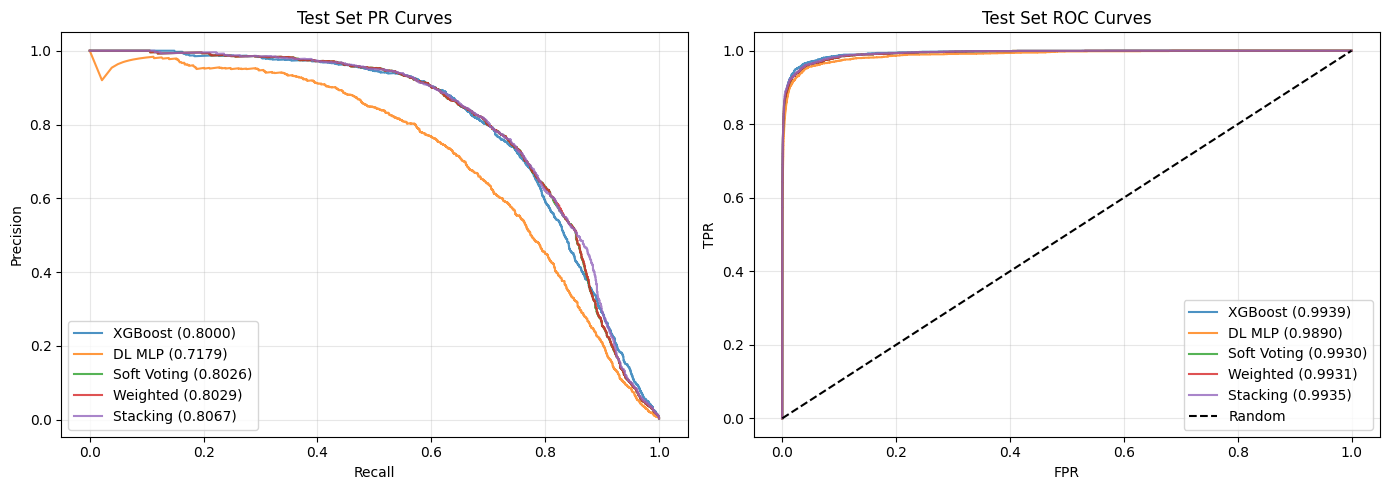

In [10]:
# ============================================================
# VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PR Curves
all_preds = {
    'XGBoost': xgb_test_proba,
    'DL MLP': dl_test_proba,
    'Soft Voting': soft_test_proba,
    'Weighted': weighted_test_proba,
    'Stacking': stack_test_proba
}

for name, proba in all_preds.items():
    prec, rec, _ = precision_recall_curve(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    axes[0].plot(rec, prec, label=f'{name} ({pr_auc:.4f})', alpha=0.8)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title('Test Set PR Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC Curves
for name, proba in all_preds.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    axes[1].plot(fpr, tpr, label=f'{name} ({auc:.4f})', alpha=0.8)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('Test Set ROC Curves')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'ensemble_pr_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Save Best Ensemble

In [11]:
# ============================================================
# SAVE BEST ENSEMBLE
# ============================================================

# Identify best approach by validation PR-AUC
best_row = ensemble_results.loc[ensemble_results['Val pr_auc'].idxmax()]
print(f"Best ensemble: {best_row['Model']}")
print(f"  Val PR-AUC: {best_row['Val pr_auc']:.4f}")
print(f"  Test PR-AUC: {best_row['Test pr_auc']:.4f}")

# Save stacking meta-learner (most flexible ensemble)
joblib.dump(meta_learner, MODELS_DIR / 'stacking_meta_learner.pkl')
print(f"\nStacking meta-learner saved: {MODELS_DIR / 'stacking_meta_learner.pkl'}")

# Save ensemble metadata
ensemble_metadata = {
    'best_approach': best_row['Model'],
    'base_models': ['xgb_best_model.pkl', 'dl_best_model.pt'],
    'weights': {'xgb': w_xgb / w_total, 'dl': w_dl / w_total},
    'stacking_threshold': stack_thresh,
    'weighted_threshold': weighted_thresh,
    'soft_threshold': soft_thresh,
    'ensemble_results': ensemble_results.to_dict('records')
}
joblib.dump(ensemble_metadata, MODELS_DIR / 'ensemble_metadata.pkl')
print(f"Ensemble metadata saved: {MODELS_DIR / 'ensemble_metadata.pkl'}")

print("\nNotebook 07 completed successfully.")

Best ensemble: XGBoost (base)
  Val PR-AUC: 0.9574
  Test PR-AUC: 0.8000

Stacking meta-learner saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/stacking_meta_learner.pkl
Ensemble metadata saved: /home/alireza/Desktop/projects/fraud-shield-ai/models/ensemble_metadata.pkl

Notebook 07 completed successfully.


## 8. Two-Stage Fraud Detection System

**Stage 1: High-Recall Gate** -- XGBoost at a low threshold (~0.10) catches 95%+ of fraud, flagging ~7% of all transactions.

**Stage 2: Precision Triage** -- Rule-based classification of flagged transactions:
- **Auto-Block:** probability >= 0.90
- **Review Queue:** 0.10 <= probability < 0.90
- **Cleared:** probability < 0.10

In [12]:
# ============================================================
# TWO-STAGE FRAUD DETECTION SYSTEM
# ============================================================

def find_recall_threshold(y_true, y_proba, target_recall=0.95):
    """Find highest threshold that achieves at least *target_recall*."""
    from sklearn.metrics import precision_recall_curve
    prec, rec, thresh = precision_recall_curve(y_true, y_proba)
    valid_mask = rec[:-1] >= target_recall
    if not np.any(valid_mask):
        return float(thresh[0])
    return float(thresh[valid_mask][-1])


# Use XGBoost probabilities (already computed)
xgb_val_proba = xgb_model.predict_proba(X_val)[:, 1]
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Stage 1 threshold: target 95% recall
stage1_threshold = find_recall_threshold(y_val, xgb_val_proba, target_recall=0.95)
print(f"Stage 1 threshold (target 95% recall): {stage1_threshold:.4f}")

# Stage 2 thresholds (rule-based triage)
STAGE2_AUTO_BLOCK = 0.90
STAGE2_REVIEW_LOWER = stage1_threshold

print(f"Stage 2 auto-block threshold: {STAGE2_AUTO_BLOCK}")
print(f"Stage 2 review lower bound: {STAGE2_REVIEW_LOWER:.4f}")

# Apply two-stage system on test set
def apply_two_stage(y_proba, stage1_thresh, auto_block_thresh):
    """Classify transactions into: cleared, review, auto-block."""
    tiers = np.full(len(y_proba), "cleared", dtype=object)
    flagged = y_proba >= stage1_thresh
    tiers[flagged & (y_proba < auto_block_thresh)] = "review"
    tiers[y_proba >= auto_block_thresh] = "auto-block"
    return tiers

val_tiers = apply_two_stage(xgb_val_proba, stage1_threshold, STAGE2_AUTO_BLOCK)
test_tiers = apply_two_stage(xgb_test_proba, stage1_threshold, STAGE2_AUTO_BLOCK)

# Evaluate
for name, tiers, y_true, y_proba in [
    ("Validation", val_tiers, y_val, xgb_val_proba),
    ("Test", test_tiers, y_test, xgb_test_proba),
]:
    n = len(y_true)
    flagged = tiers != "cleared"
    blocked = tiers == "auto-block"
    review = tiers == "review"

    stage1_recall = recall_score(y_true, flagged.astype(int))
    stage1_precision = precision_score(y_true, flagged.astype(int), zero_division=0)
    block_precision = precision_score(y_true[blocked], np.ones(blocked.sum()), zero_division=0) if blocked.sum() else 0

    print(f"\n--- {name} Two-Stage Results ---")
    print(f"  Stage 1 (flagged): {flagged.sum():,} / {n:,} ({flagged.mean():.2%})")
    print(f"    Recall:    {stage1_recall:.4f}")
    print(f"    Precision: {stage1_precision:.4f}")
    print(f"  Auto-block: {blocked.sum():,} (precision: {block_precision:.4f})")
    print(f"  Review:     {review.sum():,}")
    print(f"  Cleared:    {(~flagged).sum():,}")

    fraud_caught_block = y_true[blocked].sum() if blocked.sum() else 0
    fraud_caught_review = y_true[review].sum() if review.sum() else 0
    fraud_missed = y_true[~flagged].sum()
    total_fraud = y_true.sum()
    print(f"  Fraud caught (auto-block): {int(fraud_caught_block)} / {int(total_fraud)}")
    print(f"  Fraud caught (review):     {int(fraud_caught_review)} / {int(total_fraud)}")
    print(f"  Fraud missed:              {int(fraud_missed)} / {int(total_fraud)}")

# Save two-stage metadata
two_stage_metadata = {
    'stage1_threshold': stage1_threshold,
    'stage2_auto_block_threshold': STAGE2_AUTO_BLOCK,
    'stage2_review_lower': float(STAGE2_REVIEW_LOWER),
}

import pickle
with open(MODELS_DIR / 'two_stage_config.pkl', 'wb') as f:
    pickle.dump(two_stage_metadata, f)
print(f"\nTwo-stage config saved to {MODELS_DIR / 'two_stage_config.pkl'}")

Stage 1 threshold (target 95% recall): 0.1429
Stage 2 auto-block threshold: 0.9
Stage 2 review lower bound: 0.1429

--- Validation Two-Stage Results ---
  Stage 1 (flagged): 801 / 122,480 (0.65%)
    Recall:    0.9502
    Precision: 0.7628
  Auto-block: 601 (precision: 0.9268)
  Review:     200
  Cleared:    121,679
  Fraud caught (auto-block): 557 / 643
  Fraud caught (review):     54 / 643
  Fraud missed:              32 / 643



--- Test Two-Stage Results ---
  Stage 1 (flagged): 3,057 / 555,719 (0.55%)
    Recall:    0.8093
    Precision: 0.5679
  Auto-block: 1,747 (precision: 0.8248)
  Review:     1,310
  Cleared:    552,662
  Fraud caught (auto-block): 1441 / 2145
  Fraud caught (review):     295 / 2145
  Fraud missed:              409 / 2145

Two-stage config saved to /home/alireza/Desktop/projects/fraud-shield-ai/models/two_stage_config.pkl
